# Motif Influence and Information

Based on the method used in the Basset paper for calculating the influence of a filter...

To calculate the influence of a filter, we first set the output of the filter to the mean across all values, and then calculate the final output (predicted exon inclusion level). Then, we take the L2 norm of the vector of modified outputs subtracted by the actual network output (across all inputs), which is the influence.

In [2]:
%matplotlib inline
from keras.models import Sequential, model_from_json
from keras.layers import Convolution1D, Dense, Activation, Dropout, MaxPooling1D, Flatten, \
    GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.objectives import binary_crossentropy, categorical_crossentropy
from keras.callbacks import EarlyStopping

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils
reload(nn_utils)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

import cPickle

In [3]:
model1 = model_from_json(open('../data/2017-01-13.json').read())

/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [4]:
model1.load_weights('../data/2017-01-13.h5')

In [64]:
import draw_logo
reload(draw_logo)

<module 'draw_logo' from '/home/yjzhang/Grad_School/research_notebooks/alternative_splicing_neural_nets/src/draw_logo.py'>

In [6]:
# loading data
X_train, X_test, Y_train, Y_test = nn_utils.load_a5_data()
Y2_test = Y_test[:,44]
Y2_train = Y_train[:,44]
X1_train = X_train.map(lambda x: x[0:25])
X1_test = X_test.map(lambda x: x[0:25])
#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_train = np.dstack(X1_train)
X1_train = np.rollaxis(X1_train, 2)
X1_test = np.dstack(X1_test)
X1_test = np.rollaxis(X1_test, 2)

Y2_train = Y2_train.reshape((len(Y2_train), 1))
Y2_test = Y2_test.reshape((len(Y2_test), 1))

In [7]:
avg_filters = np.load('../data/2017-01-13-filters.npy')

In [9]:
influences = draw_logo.get_influence(model1, X1_test)

In [31]:
info = []
for i in range(200):
    info.append(6*2.0 - sum(draw_logo.entropy(avg_filters[i][j,:] for j in range(6))))

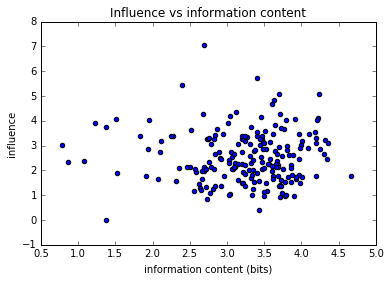

In [72]:
plt.scatter(info, influences)
plt.title('Influence vs information content')
plt.xlabel('information content (bits)')
plt.ylabel('influence')

Note: this graph is essentially the same as the one from figure 3 of the Basset paper (Basset: Learning the regulatory code of the accessible genome with deep convolutional neural networks).

In [33]:
zero_influences = draw_logo.get_influence(model1, X1_test, set_zero=True)

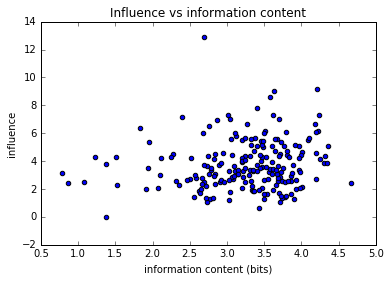

In [67]:
plt.scatter(info, zero_influences)
plt.title('Influence vs information content')
plt.xlabel('information content (bits)')
plt.ylabel('influence')

Note: the below graph is just for comparing the results from setting the filter output to the mean vs setting the filter output to 0 for the influence calculation.

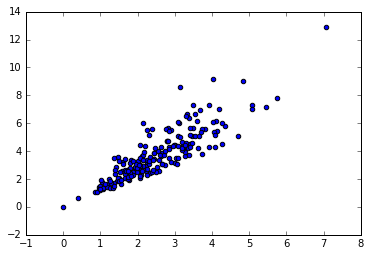

In [35]:
plt.scatter(influences, zero_influences)

In [46]:
np.argmax(influences)

2

This is supposed to be the highest influence filter. I have no idea what it should mean.

[<Container object of 6 artists>,
 <Container object of 6 artists>,
 <Container object of 6 artists>,
 <Container object of 6 artists>]

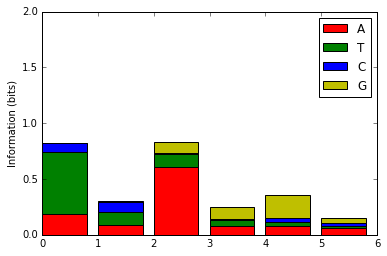

In [48]:
draw_logo.draw_logo(avg_filters[2], fixed_scale=True)

In [49]:
avg_filters[2]

array([[ 0.23164428,  0.67853909,  0.08981663,  0.        ],
       [ 0.29106927,  0.40542937,  0.27626019,  0.02724117],
       [ 0.73377603,  0.13394205,  0.01512979,  0.11715213],
       [ 0.33904316,  0.18846212,  0.06040598,  0.41208874],
       [ 0.21774072,  0.10221099,  0.11828403,  0.56176426],
       [ 0.40714609,  0.12454724,  0.16231512,  0.30599155]])

Now let's see what this motif means, if it means anything at all... let's do a search on TomTom...

http://meme-suite.org/tools/tomtom

The format is ACGT...

In [51]:
permutation = [0,2,3,1]
filter1 = avg_filters[2][:,permutation]
print '\t'.join(['A','C','G','T'])
for i in range(filter1.shape[0]):
    print '\t'.join(map(str, filter1[i,:]))

A	C	G	T
0.231644279672	0.0898166312824	0.0	0.678539087159
0.291069272014	0.27626018662	0.0272411710926	0.405429368387
0.733776032422	0.015129791701	0.11715212776	0.133942046231
0.339043162656	0.0604059763424	0.412088740545	0.18846211857
0.217740717971	0.118284032376	0.561764260938	0.102210986828
0.407146090388	0.162315121939	0.305991547868	0.124547237918


The motif search results were extremely underwhelming; nothing interesting was found.

Now let's try to do every filter...

In [57]:
output_file = open('../data/2017-01-13-motifs.txt', 'w')
output_file.write("""MEME version 4

ALPHABET= ACGT

strands: + -

Background letter frequencies
A 0.303 C 0.183 G 0.209 T 0.306

""")
permutation = [0,2,3,1]
for j in range(len(avg_filters)):
    filter1 = avg_filters[j][:,permutation]
    output_file.write('MOTIF {0}\n'.format(j))
    # okay so I literally have no idea what nsites means or E means...
    output_file.write('letter-probability matrix: alength= 4 w= 6 nsites= 6 E= 1e-010\n')
    for i in range(filter1.shape[0]):
        output_file.write(' \t'.join(map(str, filter1[i,:])))
        output_file.write('\n')
    output_file.write('\n')

## Influence for other models

While waiting for the TomTom query to finish, let's try to calculate the inflence for the simpler NN models (just a conv + global max pool, no positional information)...

In [58]:
avg_filters_2 = np.load('../data/2017-01-12-filters.npy')
avg_filters_3 = np.load('../data/2017-01-04-filters.npy')

In [59]:
model2 = model_from_json(open('../data/2017-01-12.json').read())
model2.load_weights('../data/2017-01-12.h5')
model3 = model_from_json(open('../data/2017-01-04.json').read())
model3.load_weights('../data/2017-01-04.h5')

In [61]:
influences_2 = draw_logo.get_influence(model2, X1_test)

In [62]:
influences_3 = draw_logo.get_influence(model3, X1_test)

In [65]:
info_2 = [draw_logo.information_content(m) for m in avg_filters_2]

In [66]:
info_3 = [draw_logo.information_content(m) for m in avg_filters_3]

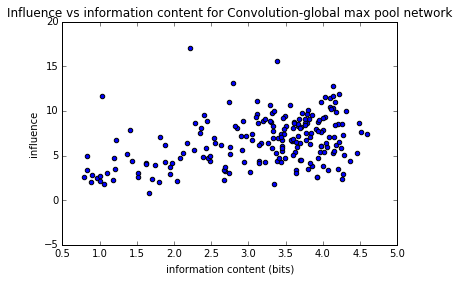

In [68]:
plt.scatter(info_2, influences_2)
plt.title('Influence vs information content for Convolution-global max pool network')
plt.xlabel('information content (bits)')
plt.ylabel('influence')

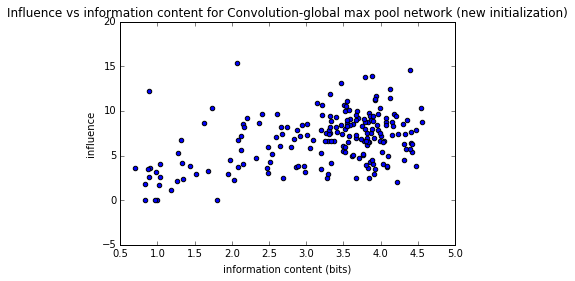

In [69]:
plt.scatter(info_3, influences_3)
plt.title('Influence vs information content for Convolution-global max pool network (new initialization)')
plt.xlabel('information content (bits)')
plt.ylabel('influence')

Maximum influence motif:

[<Container object of 6 artists>,
 <Container object of 6 artists>,
 <Container object of 6 artists>,
 <Container object of 6 artists>]

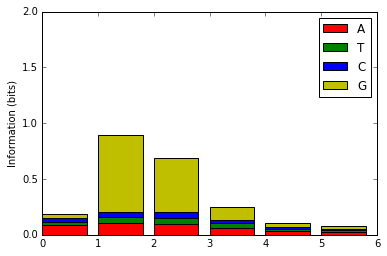

In [70]:
draw_logo.draw_logo(avg_filters_2[np.argmax(influences_2)], fixed_scale=True)

[<Container object of 6 artists>,
 <Container object of 6 artists>,
 <Container object of 6 artists>,
 <Container object of 6 artists>]

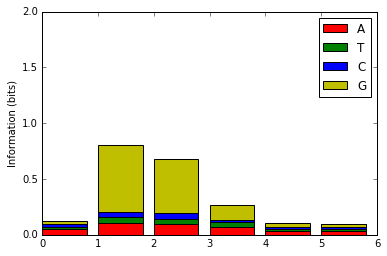

In [71]:
draw_logo.draw_logo(avg_filters_3[np.argmax(influences_3)], fixed_scale=True)

Notes: 

- the maximum influence motif doesn't seem to change across initializations, which is a good sign. The influence vs information content plots also look very similar, which indicates that the motifs should be similar across the two initializations.
- the maximum influence motif is very different from the one in the other model (accounting for positional influence)
- I have no idea why it would detect this sort of motif; it doesn't match with the 6-mers identified from HAL

In [74]:
# save influence results because they're tiresome to calculate
np.save('../data/2017-01-04-influence', np.array(influences_3))
np.save('../data/2017-01-12-influence', np.array(influences_2))
np.save('../data/2017-01-13-influence', np.array(influences))